<a href="https://githubtocolab.com/BorjaRequena/Neural-Network-Course/blob/master/nbs/course/applications/applications-tabular.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

::: {.callout-note}

In this notebook we use [random forests](https://en.wikipedia.org/wiki/Random_forest), which is a machine learning technique built upon [decision trees](https://en.wikipedia.org/wiki/Decision_tree). Furthermore, we use the [fastai](https://docs.fast.ai/) [@fastai] library to download the data for the different tasks and easily train our models.

::: 

In [ ]:
#| hide
# Uncomment and run this cell if using collab
# !pip install -U fastai
# !pip install -U scipy

In [ ]:
#| hide
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from scipy.cluster import hierarchy as hc

# Introduction

Tabular data or structured data problems are pretty common in the field of machine learning. It is the prototypical problem in which each sample is described by a certain set of features and, thus, the dataset can be layed out in a table (hence the name). The goal, then, is to predict the value of one of the columns based on the rest. Up until quite recently, tabular data problems where generally addressed with classical models based on [decision trees](https://en.wikipedia.org/wiki/Decision_tree_learning), be it [ensembles](https://en.wikipedia.org/wiki/Random_forest) or [gradient boosted machines](https://en.wikipedia.org/wiki/Gradient_boosting). However, deep learning has proven quite successful on these tasks in the past years.

Within this field, we encounter problems of all kinds, from telling flower types apart given a feature list, to assessing whether to give a loan to a bank client. Unfortunately, tabular data problems are much less nicer to show than computer vision tasks and so this part will be less flashy than the others. In order to illustrate the process, we will address a regression problem to infer the auction prices of bulldozers that was a [kaggle competition](https://www.kaggle.com/c/bluebook-for-bulldozers/overview). We will solve the same problem with random forests and neural networks in order to see what differences we find with them. 

:::{.callout-note}

We take a regression example here, but tabular data problems can also be classification tasks and all the processes shown may be applied indistinctively.

:::

Let's have a look at the data.

In [ ]:
#| code-fold: true
path = URLs.path('bluebook')

df = pd.read_csv(path/'TrainAndValid.csv', low_memory=False)
df_test = pd.read_csv(path/'Test.csv', low_memory=False)
df.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,saledate,...,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls
0,1139246,66000.0,999089,3157,121,3.0,2004,68.0,Low,11/16/2006 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
1,1139248,57000.0,117657,77,121,3.0,1996,4640.0,Low,3/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Standard,Conventional
2,1139249,10000.0,434808,7009,121,3.0,2001,2838.0,High,2/26/2004 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1139251,38500.0,1026470,332,121,3.0,2001,3486.0,High,5/19/2011 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1139253,11000.0,1057373,17311,121,3.0,2007,722.0,Medium,7/23/2009 0:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Each bulldozer is described by 53 features that constitute the columns of the dataset. 

In [ ]:
#| code-fold: true
df.columns

Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
       'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
       'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
       'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
       'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
       'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
       'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
       'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
       'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
       'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
       'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
       'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
       'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
      dtype='object')


The first thing to do is to identify our target value. In this case, it is the `SalePrice` column and, in fact, we want to predict the logarithm of the price, as stated in the competition. Then, these problems heavily rely on **feature engineering**, which consists on adding additional (smart) features that may be informative for the task. For instance, from a single date we can extract the day of the week, whether it was weekend or holidays, beginning or end of the month, etc. We could even figure out the weather if needed!

Competitions such as this one are won, in general, by those who can come up with the best relevant features for the task at hand.

In [ ]:
#| code-fold: true
dep_var = 'SalePrice'
df[dep_var] = np.log(df[dep_var])

::: {.callout-note collapse="true"}
## Expand to learn about the training details

Generally, besides feature engineering, one of the key points in this kind of problems is properly handling categorical and numerical values as well as missing values. For instance, `ProductSize` is a categorical feature which takes values 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini' and 'Compact'. The model does not konw how to process these strings and so we convert them into numerical values assigning a number to each category. These numbers have essentially no meaning. However, given the nature of decision trees, it is convenient that ordinal categories, such as this one, are ordered so that increasing numbers, for example, represent increasing categorical sizes. Numerical values, in turn, should be properly normalized (for neural networks) and, finally, missing values are filled with the mean value of the column and a new column indicating wether it was filled or not is added.  

Choosing the right validation set is also extremely important. Given that this is a price forecasting task, we will take the latest sales within the training dataset to be our validation set.

:::

In [ ]:
#| code-fold: true
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'].cat.set_categories(sizes, ordered=True, inplace=True)

df = add_datepart(df, 'saledate')
df_test = add_datepart(df_test, 'saledate')

# Split train/validation
cond = (df.saleYear<2011) | (df.saleMonth<10)
train_idx, val_idx = np.where(cond)[0], np.where(~cond)[0]
splits = (list(train_idx), list(val_idx))

# Handle continuous and categorical variables
procs = [Categorify, FillMissing]
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

# Random forests

Random forests are the go-to technique to deal with tabular data. They are extremely powerful and extremely easy to set up and train thanks to libraries like [sci-kit learn](https://scikit-learn.org/stable/).

Let's fit a [random forest regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) to the dataset and evaluate its performance. We evaluate the [root mean square error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (RMSE) of the price prediction on the validation set.

In [ ]:
#| code-fold: true
def rf(xs, y, n_estimators=40, max_samples=200_000, max_features=0.5,
       min_samples_leaf=5, **kwargs):
    "Builds and fits a `RandomForestRegressor`."
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

def r_mse(pred, y):    return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)


x, y = to.train.xs, to.train.y
valid_x, valid_y = to.valid.xs, to.valid.y

m = rf(x, y)
m_rmse(m, valid_x, valid_y)

0.232313

The RMSE is 0.23 in the logarithm of the price. Let's see how to improve on this. Random forests are quite easy to interpret and we can see, for instance, what are the most relevant features as well as those that are redundant. 

Let's have a look at the feature importances of the most significant ones (top 30).

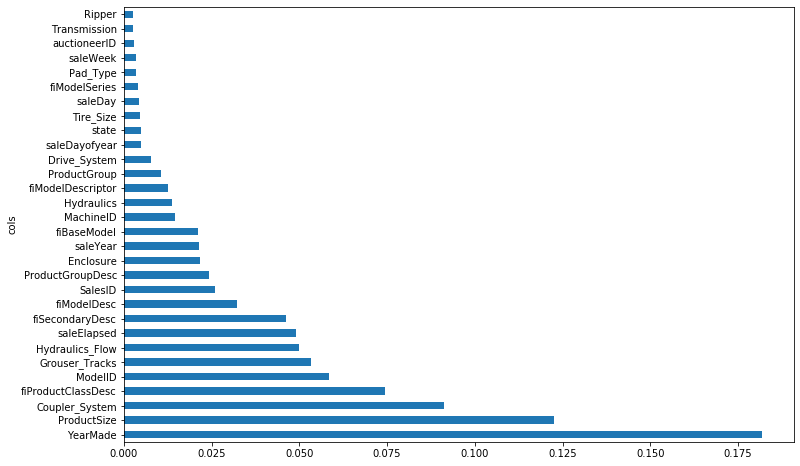

In [ ]:
#| code-fold: true
def plot_feature_importances(m, df, top=30):
    fi = pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)
    fi[:top].plot('cols', 'imp', 'barh', figsize=(12, 8), legend=False)
    return fi

fi = plot_feature_importances(m, x);

We can see that some features are much more relevant than others. For instance, the year in which the bulldozer was made and its size seem to be the most significant aspects when it comes to determining its selling price, while things such as the transmission mechanism or the day it is being sold barely have an impact. 

We will remove the least relevant features and retrain our model, leading to a simpler regressor. Therefore, if the performance is similar, it means that it will be able to generalize better. Evaluating the RMSE of the retrained model in the validation set we see that it is not only similar but, actually, a little bit better. 

In [ ]:
#| code-fold: true
to_keep = fi[fi.imp>0.005].cols
x_i, valid_x_i = x[to_keep], valid_x[to_keep]
m = rf(x_i, y)
m_rmse(m, valid_x_i, valid_y)

0.231334

Besides feature importance, we can also see which of these features are redundant or provide similar information. Removing redundant features makes our model simpler and more robust, meaning that it will generalize better to unseen data.  

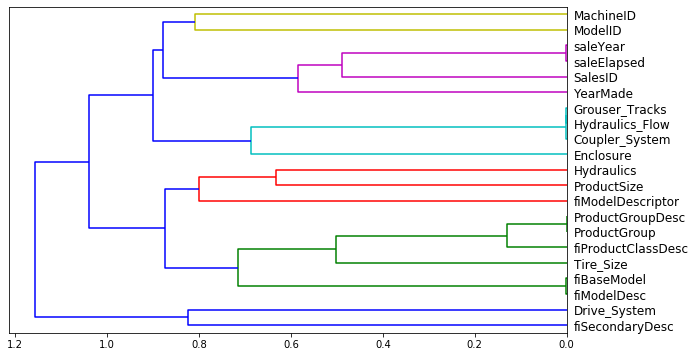

In [ ]:
#| code-fold: true
def cluster_columns(df, figsize=(10,6), font_size=12):
    corr = np.round(scipy.stats.spearmanr(df).correlation, 4)
    corr_condensed = hc.distance.squareform(1-corr)
    z = hc.linkage(corr_condensed, method='average')
    fig = plt.figure(figsize=figsize)
    hc.dendrogram(z, labels=df.columns, orientation='left', leaf_font_size=font_size)
    plt.show()
    
cluster_columns(x_i)

Those features that are merged together at the rightmost part of the plot are the ones that are the most similar. For instance, 'SaleYear' and 'SaleElapsed' provide the same information but in different formats: the first states the year it was sold and the second tells us how many years have passed since it was sold. Just like with irrelevant features, we can remove some of these redudant ones and re-evaluate our model.

In [ ]:
#| code-fold: true
to_drop = ['saleYear', 'ProductGroupDesc', 'fiBaseModel', 'Grouser_Tracks']
x_ic, valid_x_ic = x_i.drop(to_drop, axis=1), valid_x_i.drop(to_drop, axis=1)
m = rf(x_ic, y)
m_rmse(m, valid_x_ic, valid_y)

0.232922

Dropping the least informative features and some of the redundant ones, we have greatly simplified our model while keeping the same performance. This will allow the model to generalize much, much better. We could keep up with the model interpretation and feature engineering, but it is beyond the scope of this lesson. Some other features that we can drop are time-stamp variables, such as MachineID and SalesID, as well as some model identification ones. This is because, with the model in production, when we want to infer the price of a bulldozer that is currently being sold, the time-stamp-related features do not provide any significant information to the random forest, provided that it is completely unable to generalize beyond what it has seen during training. For an in-depth explanation, check the [lesson 7 of fastai's 2020 course](https://course.fast.ai/videos/?lesson=7). 

We will proceed now to do the prediction by training a neural network.

# Neural networks

While random forests do great work, they are completely unable to extrapolate to regions beyond the limits of the training data. It may not be the end of the world for some tasks, but it is definitely terrible for some others. 

However, as we have seen, those models can be extremely helpful to understand the data and get an idea of the most important features, as they are very easily interpretable. Therefore, we will combine both approaches and take advantage of the feature analysis that we have performed with the random forest. This way, we will get rid of some of the meaningless features straight away before training the network.

::: {.callout-note collapse="true"}
## Expand to learn about the training details

The neural network will have to deal with continuous and categorical variables in a completely different way. We will create an [embdedding](https://towardsdatascience.com/neural-network-embeddings-explained-4d028e6f0526) for each categorical variable, while the numerical ones are just input into a fully connected layer. Then, everything is brought together in a dense classifier at the end. Therefore, it is importnat that we split the variables into numerical and categorical and, in fact, categorical variables with high cardinality, like `saleElapsed`, may be dealt with as numerical ones to prevent massive embeddings. 

:::

Let's train!

In [ ]:
#| code-fold: true
x_ic = x_ic.drop(['SalesID', 'MachineID', 'fiModelDescriptor'], axis=1)
df_nn = df[list(x_ic.columns) + [dep_var]] # Keep only useful features

cont_nn, cat_nn = cont_cat_split(df_nn, max_card=9000, dep_var=dep_var)

cont_nn.append('saleElapsed')
cat_nn.remove('saleElapsed')
df_nn.saleElapsed.dtype = int

procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn, splits=splits, y_names=dep_var)
dls = to_nn.dataloaders(1024)

learn = tabular_learner(dls, y_range=(8,12), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

learn.fit_one_cycle(5, 1e-2)

epoch,train_loss,valid_loss,time
0,0.070896,0.063198,00:07
1,0.056112,0.067255,00:07
2,0.049322,0.054010,00:07
3,0.043438,0.051197,00:07
4,0.040356,0.051439,00:07


In order to compare the random forest with the neural network we have to check what the RMSE is.

In [ ]:
#| code-fold: true
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.226801

The neural network provides a much better result than the random forest predicting the sales price of bulldozers. This is, mainly, due to the hard limitation in extrapolation of random forests, which make them struggle in forecasting tasks such as this one where prices evolve through time and we have to make inferences in the future. 

This has been only one example of how to apply machine learning to tabular data. As you can see, these kind of problems offer a much more engaging relationship in the feature engineering part, provided that we feed the data straight into the classifier.